# Importing necessary libraries

In [8]:
# importing necessary libraries into the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import scipy.stats as stats
import re
# import warnings
# warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Data
## Import the Cleaned Dataset

In [5]:
#loading the dataset into the dataframes
results = pd.read_csv("results.csv")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

## Check if the data was successfully loaded or not

In [7]:
results.head()

,season,round,position,grid,lat,long,driverExperience,teamStrength,driverAge,experience_group
0,2009,1,1,1,-37.8497,144.968,9,12.696735,29,High
1,2009,1,2,2,-37.8497,144.968,16,1.000000,36,Very High
2,2009,1,3,20,-37.8497,144.968,12,11.711382,34,High
3,2009,1,4,19,-37.8497,144.968,5,11.676113,27,Medium
4,2009,1,5,10,-37.8497,144.968,8,10.515723,27,High


## Model Training
## Random Forest Regressor
### Setting Up Feature and Target

In [9]:
num_features = [
    'season', 'round', 'grid', 'lat', 'long', 'driverExperience', 'teamStrength', 
    'driverAge']
target = 'position'

## One‑Hot Encoding Experience Group

In [10]:
X_cat = pd.get_dummies(
    results['experience_group'],
    drop_first = True
)

X_num = results[num_features]

X = pd.concat([X_num, X_cat], axis=1)
y = results[target]

## Train‑Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.3,
    random_state = 42
)

X_train.shape, X_test.shape

((4328, 11), (1855, 11))

## Baseline Random Forest Model

In [12]:
rf = RandomForestRegressor(
    n_estimators = 200,
    random_state = 42,
    n_jobs = -1
)

rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

## Evaluation of Baseline Model

In [13]:
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest MAE : {mae:.2f}")
print(f"Random Forest RMSE : {rmse:.2f}")
print(f"Random Forest R² : {r2:.3f}")

Random Forest MAE : 3.26
Random Forest RMSE : 4.29
Random Forest R² : 0.437


## Hyperparameter Tuning with GridSearchCV

In [15]:
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(
    random_state = 42,
    n_jobs = -1
)

grid_rf = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    scoring = 'r2',
    cv = 5,
    verbose = 1
)

grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [200, 300]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candi

## Best Random Forest Model Evaluation

In [16]:
best_rf = grid_rf.best_estimator_

y_pred_best = best_rf.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("Best Parameters:", grid_rf.best_params_)
print(f"Tuned RF MAE : {mae_best:.2f}")
print(f"Tuned RF RMSE : {rmse_best:.2f}")
print(f"Tuned RF R² : {r2_best:.3f}")

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Tuned RF MAE : 3.20
Tuned RF RMSE : 4.20
Tuned RF R² : 0.459


## Feature Importance

In [17]:
importances = best_rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by = 'Importance', ascending = False)

importance_df

,Feature,Importance
2,grid,0.551451
6,teamStrength,0.204250
0,season,0.043202
1,round,0.042329
7,driverAge,0.040964
3,lat,0.038524
4,long,0.036353
5,driverExperience,0.033712
9,Medium,0.005895
8,Low,0.002650


## Plotting Feature Importance

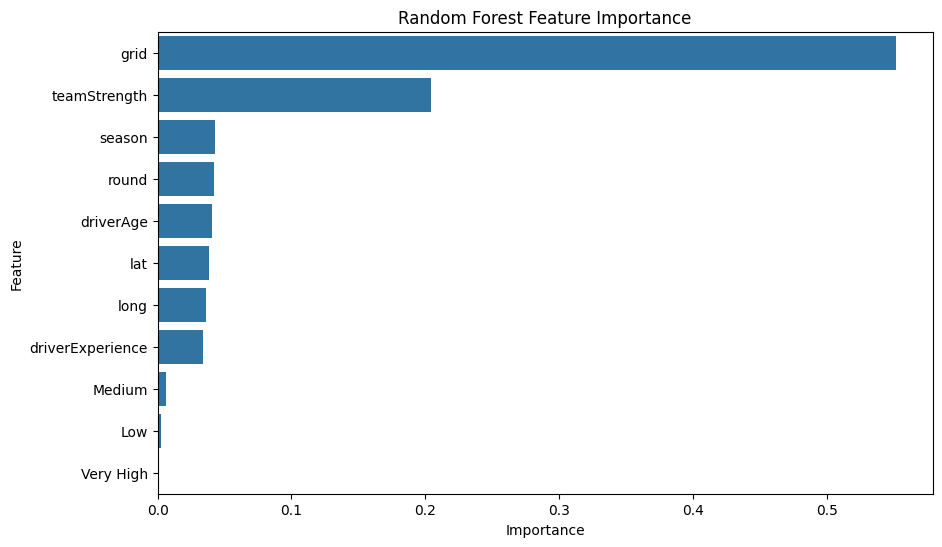

In [18]:
plt.figure(figsize = (10, 6))
sns.barplot(
    data = importance_df,
    x = 'Importance',
    y = 'Feature'
)
plt.title("Random Forest Feature Importance")
plt.show()

## Comparison Table

In [19]:
rf_results = pd.DataFrame({
    'Model': ['Tuned Random Forest'],
    'MAE': [mae_best],
    'RMSE': [rmse_best],
    'R²': [r2_best]
})

rf_results

,Model,MAE,RMSE,R²
0,Tuned Random Forest,3.199319,4.204644,0.458832
